In [96]:
!pip install lightgbm

C:\Users\arias\anaconda3\lib\site-packages\IPython\utils\_process_win32.py:145: ResourceWarning: unclosed file <_io.BufferedWriter name=5>
  return process_handler(cmd, _system_body)
C:\Users\arias\anaconda3\lib\site-packages\IPython\utils\_process_win32.py:145: ResourceWarning: unclosed file <_io.BufferedReader name=6>
  return process_handler(cmd, _system_body)
C:\Users\arias\anaconda3\lib\site-packages\IPython\utils\_process_win32.py:145: ResourceWarning: unclosed file <_io.BufferedReader name=7>
  return process_handler(cmd, _system_body)


In [97]:
!pip install catboost

In [98]:
!pip install skforecast

In [99]:
! pip install scikit-learn

In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelado y Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
import sklearn.metrics 

import sklearn.metrics as metrics
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')
%config Completer.use_jedi = False

In [85]:
# load data
data = pd.read_excel(r'C:\Users\arias\Desktop\DataSet\recaudoDiarioConfinDeSemana2.xlsx')


In [86]:
data['value'] = data['value'].astype('float') 

In [87]:
data

,fecha,value
0,2019-07-04,932383252.0
1,2019-07-05,263540907.0
2,2019-07-06,0.0
3,2019-07-07,0.0
4,2019-07-08,301014942.0
...,...,...
732,2021-07-05,0.0
733,2021-07-06,763135176.0
734,2021-07-07,363085445.0
735,2021-07-08,236200655.0


In [45]:
# Se parten los datos para entrenamiento, validación y test.
fin_train = '2020-07-04' 
fin_validacion = '2021-05-10' 
datos_train = data.loc[0:478]
datos_val   = data.loc[479:600]
datos_test  = data.loc[601:737]

In [46]:
print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train      : 0 --- 478  (n=479)
Fechas validacion : 479 --- 600  (n=122)
Fechas test       : 601 --- 736  (n=136)


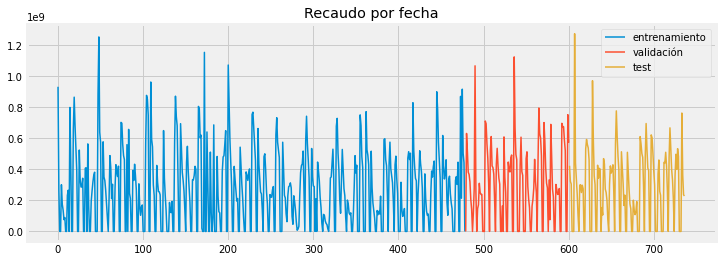

In [47]:
# Se grafican datos entrenamiento, validación y test.
fig, ax = plt.subplots(figsize=(11, 4))
datos_train['value'].plot(ax=ax, label='entrenamiento')
datos_val['value'].plot(ax=ax, label='validación')
datos_test['value'].plot(ax=ax, label='test')
ax.set_title('Recaudo por fecha')
ax.legend();

In [48]:
# Se crea el dataframe datos 
datos=data


In [49]:
# Entrenamiento del modelo
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 30
             )

forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
Window size: 30 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Re

In [50]:
# se configura la fecha como indice(por ser series temporales)
data = data.set_index('fecha')

In [51]:
datos

,fecha,value
0,2019-07-04,932383252.0
1,2019-07-05,263540907.0
2,2019-07-06,0.0
3,2019-07-07,0.0
4,2019-07-08,301014942.0
...,...,...
732,2021-07-05,0.0
733,2021-07-06,763135176.0
734,2021-07-07,363085445.0
735,2021-07-08,236200655.0


In [52]:
# Hiperparámetros del regresor.  Se identifica la combinación de hiperparámetros y lags con los que se consigue menor error.
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.09, 0.1, 0.15]
}

# Lags utilizados como predictores
lags_grid = [7, 30, [1, 2, 3]]


resultados_grid = grid_search_forecaster(
        forecaster         = forecaster,
        y                  = datos.loc[:600, 'value'], # conjunto de train y validación
        param_grid         = param_grid,
        lags_grid          = lags_grid,
        steps              = 90,
        refit              = False,
        metric             = 'mean_squared_error',
        initial_train_size = int(len(datos_train)), # El modelo se entrena con los datos de entrenamiento
        return_best        = True,
        verbose            = False
)

Number of models compared: 54


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [01:10<00:00, 23.49s/it]


Refitting `forecaster` using the best found parameters and the whole data set: 
  lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
  params: {'learning_rate': 0.09, 'max_depth': 5, 'n_estimators': 500}



In [53]:
resultados_grid.head(10)

,lags,params,metric,learning_rate,max_depth,n_estimators
21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.09, 'max_depth': 5, 'n_est...",3.009636e+16,0.09,5.0,500.0
35,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.15, 'max_depth': 10, 'n_es...",3.160482e+16,0.15,10.0,500.0
22,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.09, 'max_depth': 10, 'n_es...",3.191153e+16,0.09,10.0,100.0
34,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.15, 'max_depth': 10, 'n_es...",3.209638e+16,0.15,10.0,100.0
20,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.09, 'max_depth': 5, 'n_est...",3.290839e+16,0.09,5.0,100.0
33,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.15, 'max_depth': 5, 'n_est...",3.308887e+16,0.15,5.0,500.0
23,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.09, 'max_depth': 10, 'n_es...",3.344051e+16,0.09,10.0,500.0
24,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",3.406143e+16,0.10,3.0,100.0
32,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.15, 'max_depth': 5, 'n_est...",3.448678e+16,0.15,5.0,100.0
26,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",3.640480e+16,0.10,5.0,100.0


In [54]:
# Backtesting
# ==============================================================================
metric, predicciones = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos['value'],
    initial_train_size = len(datos.loc[:600]),
    steps      = 30,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
)

print(f"Error de backtest: {metric}")

Error de backtest: [2.5331045e+16]


In [55]:
predicciones

,pred
601,445298752.0
602,382567424.0
603,236680752.0
604,26105460.0
605,188543552.0
...,...
732,273878656.0
733,304710656.0
734,351650048.0
735,309895328.0


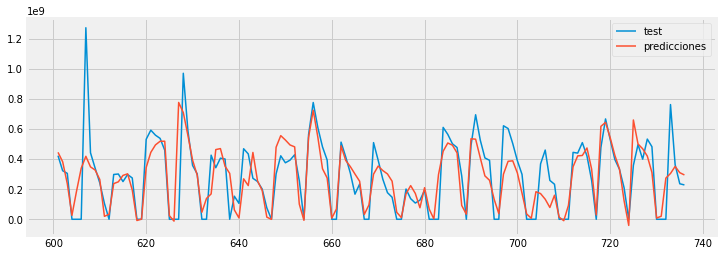

In [56]:
fig, ax = plt.subplots(figsize=(11, 4))
datos_test['value'].plot(ax=ax, label='test')
predicciones['pred'].plot(ax=ax, label='predicciones')
ax.legend();

In [57]:
forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.09, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
Window size: 30 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 600] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'objective': 'reg:squar

In [58]:
# Gráfico interactivo serie temporal
# ==============================================================================
datos_plot = pd.DataFrame({
                'test': datos_test['value'],
                'prediccion': predicciones['pred'],

                 })
datos_plot.index.name = 'date_time'

fig = px.line(
    data_frame = datos_plot.reset_index(),
    x      = 'date_time',
    y      = datos_plot.columns,
    title  = 'Valor Recaudo',
    width  = 900,
    height = 500
)

fig.update_xaxes(rangeslider_visible=True)
fig.show()

#### Predicción datos futuros 1

In [59]:
predic_datos_futuros1= forecaster.predict(steps= 200)
predic_datos_futuros1.head(10)

601    445298752.0
602    382567424.0
603    236680752.0
604     26105460.0
605    188543552.0
606    339720544.0
607    418914592.0
608    348553888.0
609    327561664.0
610    264617376.0
Name: pred, dtype: float64

In [60]:
#predic_datos_futuros1.to_excel('predic_datos_futuros1.xlsx')    

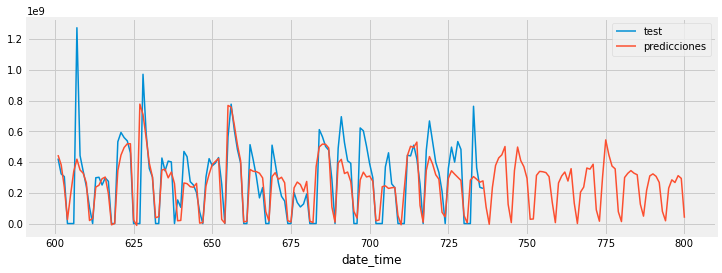

In [61]:
fig, ax = plt.subplots(figsize=(11, 4))
datos_test['value'].plot(ax=ax, label='test')
predic_datos_futuros1.plot(ax=ax, label='predicciones')
ax.legend();

## Variables exógenas
Se agregó una columna con un 1 para día laboral y ceros para sábados y domingos.

In [62]:
from datetime import datetime

In [88]:
# load data
data = pd.read_excel(r'C:\Users\arias\Desktop\DataSet\recaudoDiarioConfinDeSemana2.xlsx')

In [89]:
data

,fecha,value
0,2019-07-04,932383252
1,2019-07-05,263540907
2,2019-07-06,0
3,2019-07-07,0
4,2019-07-08,301014942
...,...,...
732,2021-07-05,0
733,2021-07-06,763135176
734,2021-07-07,363085445
735,2021-07-08,236200655


In [70]:
datos

,fecha,value
0,2019-07-04,932383252.0
1,2019-07-05,263540907.0
2,2019-07-06,0.0
3,2019-07-07,0.0
4,2019-07-08,301014942.0
...,...,...
732,2021-07-05,0.0
733,2021-07-06,763135176.0
734,2021-07-07,363085445.0
735,2021-07-08,236200655.0


In [90]:
dataos =data


In [91]:
data['weekend'] = np.where(data1.index.dayofweek < 5, 1, 0)
#data['weekend'] = data1['weekend'].astype('category')

In [92]:
data.head(20)

,fecha,value,weekend
0,2019-07-04,932383252,1
1,2019-07-05,263540907,1
2,2019-07-06,0,0
3,2019-07-07,0,0
4,2019-07-08,301014942,1
5,2019-07-09,175079127,1
6,2019-07-10,137211552,1
7,2019-07-11,75995494,1
8,2019-07-12,89353363,1
9,2019-07-13,0,0


In [93]:
# Como los datos han sido modificados, se repite el reparto en train, val y test.
datos_train = data.loc[0:478]
datos_val   = data.loc[479:600]
datos_test  = data.loc[601:737]

In [94]:
# Se entrena nuevamente el modelo
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 30
             )

forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
Window size: 30 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Re

In [96]:
# Hiperparámetros del regresor
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.09, 0.1, 0.15]
}

# Lags utilizados como predictores
lags_grid = [7, 30, [1, 2, 3]]


resultados_grid = grid_search_forecaster(
        forecaster         = forecaster,
        y                  = data.loc[:600, 'value'], # conjunto de train y validación
        param_grid         = param_grid,
        lags_grid          = lags_grid,
        steps              = 60, # Número de pasos a predecir
        refit              = False,
        metric             = 'mean_squared_error', #error cuadrático medio
        initial_train_size = int(len(datos_train)), # El modelo se entrena con los datos de entrenamiento
        return_best        = True,
        verbose            = False
)

Number of models compared: 54


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [01:13<00:00, 24.43s/it]


Refitting `forecaster` using the best found parameters and the whole data set: 
  lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
  params: {'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 100}



In [97]:
forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.15, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
Window size: 30 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 600] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'objective': 'reg:squar

In [98]:
# Backtesting
# ==============================================================================
metric, predicciones = backtesting_forecaster(
    forecaster = forecaster,
    y          = data['value'],
    initial_train_size = len(data.loc[:600]),
    steps      = 30,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
)

print(f"Error de backtest: {metric}")

Error de backtest: [2.40807353e+16]


In [99]:
# Gráfico interactivo serie temporal
# ==============================================================================
datos_plot = pd.DataFrame({
                'test': datos_test['value'],
                'prediccion': predicciones['pred'],

                 })
datos_plot.index.name = 'date_time'

fig = px.line(
    data_frame = datos_plot.reset_index(),
    x      = 'date_time',
    y      = datos_plot.columns,
    title  = 'Valor Recaudo',
    width  = 900,
    height = 500
)

fig.update_xaxes(rangeslider_visible=True)
fig.show()

#### Predicción datos futuros exógena

In [100]:
predic_datos_futuros_exogena= forecaster.predict(steps= 200)
predic_datos_futuros_exogena

601    436329376.0
602    356473440.0
603    258127392.0
604     51136620.0
605    151903776.0
          ...     
796    581539968.0
797    584157440.0
798    580660992.0
799    578306176.0
800     37573056.0
Name: pred, Length: 200, dtype: float64

In [101]:
#predic_datos_futuros_exogena.to_excel('predic_datos_futuros_exogena.xlsx')

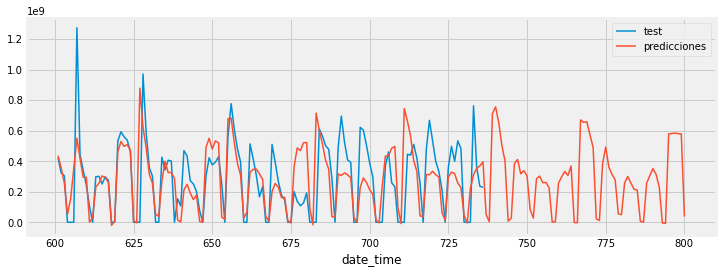

In [102]:
fig, ax = plt.subplots(figsize=(11, 4))
datos_test['value'].plot(ax=ax, label='test')
predic_datos_futuros_exogena.plot(ax=ax, label='predicciones')
ax.legend();

## LBM REGRESSOR


In [103]:
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags = 30
             )

forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
Window size: 30 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2022-02-02 11:40:56 
Last fit date: None 
Skforecast version: 0.4.1 

In [104]:
data

,fecha,value,weekend
0,2019-07-04,932383252,1
1,2019-07-05,263540907,1
2,2019-07-06,0,0
3,2019-07-07,0,0
4,2019-07-08,301014942,1
...,...,...,...
732,2021-07-05,0,1
733,2021-07-06,763135176,1
734,2021-07-07,363085445,1
735,2021-07-08,236200655,1


In [105]:
# Hiperparámetros del regresor
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.09, 0.1, 0.15]
}

# Lags utilizados como predictores
lags_grid = [7, 30, [1, 2, 3]]


resultados_grid = grid_search_forecaster(
        forecaster         = forecaster,
        y                  = data.loc[:600, 'value'], # conjunto de train y validación
        param_grid         = param_grid,
        lags_grid          = lags_grid,
        steps              = 60,
        refit              = False,
        metric             = 'mean_squared_error',
        initial_train_size = int(len(datos_train)), # El modelo se entrena con los datos de entrenamiento
        return_best        = True,
        verbose            = False
)

Number of models compared: 54


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:12<00:00,  4.11s/it]


Refitting `forecaster` using the best found parameters and the whole data set: 
  lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
  params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}



In [106]:
data

,fecha,value,weekend
0,2019-07-04,932383252,1
1,2019-07-05,263540907,1
2,2019-07-06,0,0
3,2019-07-07,0,0
4,2019-07-08,301014942,1
...,...,...,...
732,2021-07-05,0,1
733,2021-07-06,763135176,1
734,2021-07-07,363085445,1
735,2021-07-08,236200655,1


In [107]:
# Backtesting
# ==============================================================================
metric, predicciones = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos['value'],
    initial_train_size = len(data.loc[:600]),
    steps      = 30,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
)

print(f"Error de backtest: {metric}")

Error de backtest: [2.50191774e+16]


In [108]:
# Gráfico interactivo serie temporal
# ==============================================================================
datos_plot = pd.DataFrame({
                'test': datos_test['value'],
                'prediccion': predicciones['pred'],

                 })
datos_plot.index.name = 'date_time'

fig = px.line(
    data_frame = datos_plot.reset_index(),
    x      = 'date_time',
    y      = datos_plot.columns,
    title  = 'Valor Recaudo',
    width  = 900,
    height = 500
)

fig.update_xaxes(rangeslider_visible=True)
fig.show()

#### Predicción datos futuros LBM

In [109]:
predic_datos_futuros_LBM= forecaster.predict(steps= 200)
predic_datos_futuros_LBM

601    4.683308e+08
602    3.765716e+08
603    1.814025e+08
604    2.083466e+07
605    1.406254e+08
           ...     
796    3.593827e+08
797    2.361716e+08
798    1.633232e+08
799    1.042862e+08
800   -2.411877e+07
Name: pred, Length: 200, dtype: float64

In [110]:
#predic_datos_futuros_LBM.to_excel('predic_datos_futuros_LBM.xlsx')

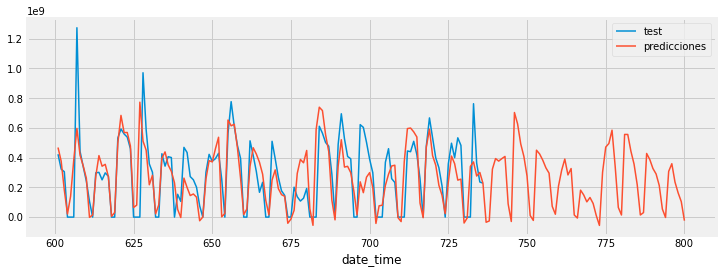

In [111]:
fig, ax = plt.subplots(figsize=(11, 4))
datos_test['value'].plot(ax=ax, label='test')
predic_datos_futuros_LBM.plot(ax=ax, label='predicciones')
ax.legend();

## CATBOOST
CatBoost se basa en la teoría de los árboles de decisión y la potenciación de gradientes. La idea principal de impulsar es combinar secuencialmente muchos modelos débiles (un modelo que funciona ligeramente mejor que el azar) y, por lo tanto, a través de la búsqueda codiciosa, crear un modelo predictivo competitivo fuerte.Debido a que el aumento de gradiente se ajusta secuencialmente a los árboles de decisión, los árboles ajustados aprenderán de los errores de los árboles anteriores y, por lo tanto, reducirán los errores.

In [112]:
forecaster = ForecasterAutoreg(
                regressor = CatBoostRegressor(random_state=123, silent=True),
                lags = 30
             )

forecaster

ForecasterAutoreg 
Regressor: <catboost.core.CatBoostRegressor object at 0x0000017DFB620490> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
Window size: 30 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'loss_function': 'RMSE', 'silent': True, 'random_state': 123} 
Creation date: 2022-02-02 11:42:36 
Last fit date: None 
Skforecast version: 0.4.1 

In [115]:
data

,fecha,value,weekend
0,2019-07-04,932383252,1
1,2019-07-05,263540907,1
2,2019-07-06,0,0
3,2019-07-07,0,0
4,2019-07-08,301014942,1
...,...,...,...
732,2021-07-05,0,1
733,2021-07-06,763135176,1
734,2021-07-07,363085445,1
735,2021-07-08,236200655,1


In [116]:
# Hiperparámetros del regresor
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.09, 0.1, 0.15]
}

# Lags utilizados como predictores
lags_grid = [7, 30, [1, 2, 3]]


resultados_grid = grid_search_forecaster(
        forecaster         = forecaster,
        y                  = data.loc[:600, 'value'], # conjunto de train y validación
        param_grid         = param_grid,
        lags_grid          = lags_grid,
        steps              = 60,
        refit              = False,
        metric             = 'mean_squared_error',
        initial_train_size = int(len(datos_train)), # El modelo se entrena con los datos de entrenamiento
        return_best        = True,
        verbose            = False
)

Number of models compared: 54


loop lags_grid: 100%|██████████████████████████████████████| 3/3 [06:28<00:00, 129.64s/it]


Refitting `forecaster` using the best found parameters and the whole data set: 
  lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
  params: {'learning_rate': 0.09, 'max_depth': 3, 'n_estimators': 100}



In [117]:
# Backtesting
# ==============================================================================
metric, predicciones = backtesting_forecaster(
    forecaster = forecaster,
    y          = datos['value'],
    initial_train_size = len(datos.loc[:600]),
    steps      = 30,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
)

print(f"Error de backtest: {metric}")

Error de backtest: [2.25409554e+16]


In [118]:
datos_plot = pd.DataFrame({
                'test': datos_test['value'],
                'prediccion': predicciones['pred'],

                 })
datos_plot.index.name = 'date_time'

fig = px.line(
    data_frame = datos_plot.reset_index(),
    x      = 'date_time',
    y      = datos_plot.columns,
    title  = 'Valor Recaudo',
    width  = 900,
    height = 500
)

fig.update_xaxes(rangeslider_visible=True)
fig.show()

#### Predicción datos futuros_CATBOOST

In [119]:
predic_datos_futuros_CATBOOST= forecaster.predict(steps= 168)
predic_datos_futuros_CATBOOST

601    4.572678e+08
602    3.881533e+08
603    2.554501e+08
604   -2.481475e+06
605    9.557166e+07
           ...     
764    2.022191e+08
765   -2.791981e+07
766   -8.277224e+06
767    3.073300e+08
768    4.630339e+08
Name: pred, Length: 168, dtype: float64

In [120]:
predic_datos_futuros_CATBOOST.to_excel('predic_datos_futuros_CATBOOST.xlsx')

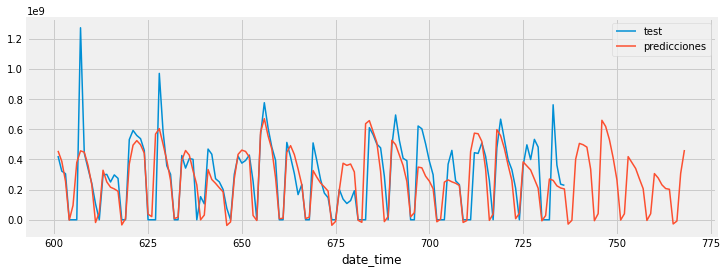

In [121]:
fig, ax = plt.subplots(figsize=(11, 4))
datos_test['value'].plot(ax=ax, label='test')
predic_datos_futuros_CATBOOST.plot(ax=ax, label='predicciones')
ax.legend();